# Turn-over examples

In this notebook we will show how to perform turn-over fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.
See https://arxiv.org/pdf/2302.07484.pdf.

Authors:
- Benedict Bahr-Kalus
- Arnaud de Mattia

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.arange(0., 0.12, 0.002)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk_interpolator = cosmo.get_fourier().pk_interpolator(of='delta_cb')
#from cosmoprimo import PowerSpectrumBAOFilter
#filter = PowerSpectrumBAOFilter(pk_interpolator, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo)
#pk_interpolator = filter.smooth_pk_interpolator()
pk = pk_interpolator(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

## Turnover likelihood

In [2]:
from desilike.theories.galaxy_clustering import TurnOverPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = TurnOverPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
theory.init.params['sn0'].update(fixed=True)  # let's fix sn0
# transform='cubic' to gaussianize the likelihood, eq. 16 of https://arxiv.org/pdf/2302.07484.pdf
observable = TracerPowerSpectrumMultipolesObservable(data=mocks, covariance=mocks,  # fit mean of mocks
                                                     klim={0: [0.002, 0.09, 0.002]}, # fit monopole, between 0.002 and 0.09 h/Mpc 
                                                     theory=theory,
                                                     transform='cubic')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

[000000.71] [0/1] 09-11 09:23  ObservablesGaussianLikelihood INFO     Covariance matrix with 44 points built from 1000 observations.
[000000.71] [0/1] 09-11 09:23  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9550.


-5899.510476122588

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=2)

print(profiles.to_stats(tablefmt='pretty'))

[000004.34] [0/1] 09-11 09:23  MinuitProfiler            INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
+-------------------------------------+--------+---------+-------+
| chi2 / (44 - 4) = 47.86 / 40 = 1.20 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|                  m                  |  True  |  1.52   | 0.73  |
|                  n                  |  True  |  0.641  | 0.017 |
|                 qto                 |  True  |  0.674  | 0.068 |
|                 b1                  |  True  |  2.017  | 0.051 |
+-------------------------------------+--------+---------+-------+


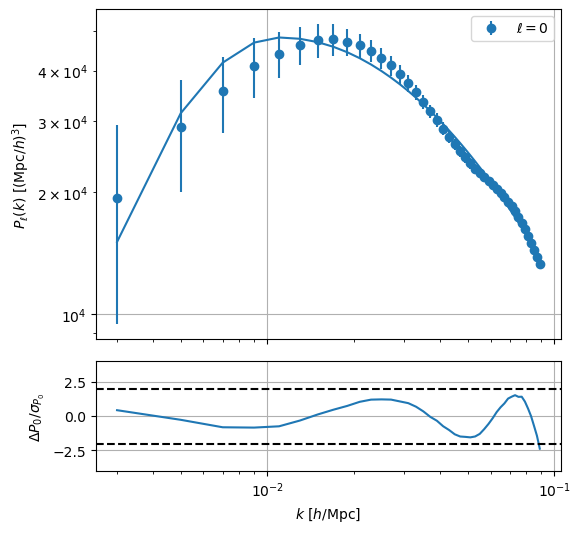

In [11]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot(scaling='loglog')
plt.show()

In [4]:
observable.plot(scaling='loglog', interactive={'params': profiles.bestfit.choice(input=True)})

interactive(children=(FloatSlider(value=1.0, description='$q_{\\mathrm{ap}}$ : ', max=1.05, min=0.95, step=0.0…

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [5]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.1})

[000006.99] [0/1] 09-07 11:39  EmceeSampler              INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
[000028.67] [0/1] 09-07 11:39  EmceeSampler              INFO     Diagnostics:
[000028.69] [0/1] 09-07 11:39  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 3.97; not < 0.1.
[000028.70] [0/1] 09-07 11:39  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.472.
[000029.02] [0/1] 09-07 11:39  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.806.
[000029.02] [0/1] 09-07 11:39  EmceeSampler              INFO     - max Geweke is 0.438.
[000029.03] [0/1] 09-07 11:39  EmceeSampler              INFO     - Geweke p-value is 0.233.
[000029.04] [0/1] 09-07 11:39  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 10.9.


/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000052.78] [0/1] 09-07 11:40  EmceeSampler              INFO     Diagnostics:
[000052.79] [0/1] 09-07 11:40  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.331; not < 0.1.
[000052.80] [0/1] 09-07 11:40  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0346.
[000053.43] [0/1] 09-07 11:40  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.267.
[000053.44] [0/1] 09-07 11:40  EmceeSampler              INFO     - max Geweke is 0.297.
[000053.44] [0/1] 09-07 11:40  EmceeSampler              INFO     - Geweke p-value is 0.207.
[000053.46] [0/1] 09-07 11:40  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 12.3.
[000053.46] [0/1] 09-07 11:40  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.494.
[000073.45] [0/1] 09-07 11:40  EmceeSampler              INFO     Diagnostics:
[000073.46] [0/1] 09-07 11:40  EmceeSampler              INFO     

In [6]:
chain = chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+-----+--------+-------+--------+-------+-----------------+-----------------+
|     | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+-----+--------+-------+--------+-------+-----------------+-----------------+
|  m  |  1.45  | 1.81  |  1.68  | 0.85  |   -0.80/+0.79   |   -0.97/+0.54   |
|  n  | 0.642  | 0.638 | 0.638  | 0.017 |  -0.017/+0.017  |  -0.020/+0.013  |
| qto | 0.673  | 0.658 | 0.658  | 0.066 |  -0.069/+0.067  |  -0.064/+0.070  |
| b1  | 2.021  | 2.032 | 2.028  | 0.052 |  -0.052/+0.052  |  -0.054/+0.049  |
+-----+--------+-------+--------+-------+-----------------+-----------------+


Removed no burn in


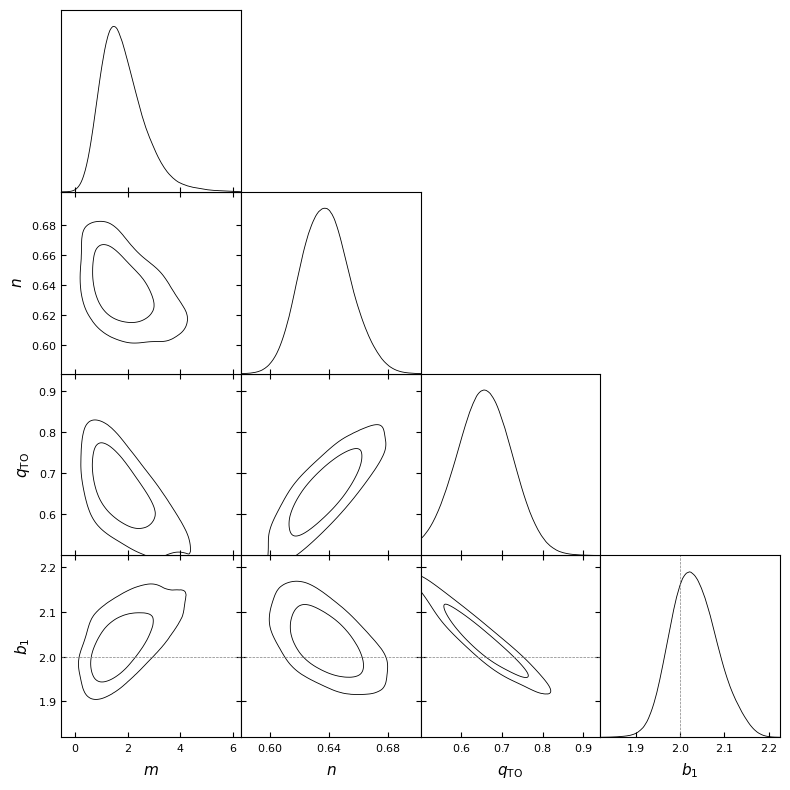

In [7]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qto': 1., 'b1': b})

$q_{\mathrm{TO}} = k_{\mathrm{TO}}^{\mathrm{obs}} / k_{\mathrm{TO}}^{\mathrm{fid}}$ is biased low, as noticed in fig. 1 of https://arxiv.org/pdf/2302.07484.pdf, and the $\chi^{2}$ is high.

## Deprojection of BAO wiggles
We follow section 2.2 of https://arxiv.org/pdf/2302.07484.pdf. Let's generate a model with BAO wiggles, fitting the data.

In [8]:
observable_temp = observable.deepcopy()
kTO_fid = template.kTO_fid
observable_temp.init.update(covariance=np.diag((np.concatenate(observable.k) - kTO_fid)**2))
likelihood_temp = ObservablesGaussianLikelihood(observables=[observable_temp])
likelihood_temp.all_params['qto'].update(value=1., fixed=True)

In [9]:
profiler = MinuitProfiler(likelihood_temp, seed=42)
profiles = profiler.maximize(niterations=1)
print(profiles.to_stats(tablefmt='pretty'))

[000347.35] [0/1] 09-07 11:44  MinuitProfiler            INFO     Varied parameters: ['m', 'n', 'b1'].
+--------------------------------------------------------+--------+-------------+--------+
| chi2 / (44 - 3) = 245428828979.26 / 41 = 5986068999.49 | varied |   bestfit   | error  |
+--------------------------------------------------------+--------+-------------+--------+
|                           m                            |  True  | 0.67227598  | 2.9e-7 |
|                           n                            |  True  | 1.01831430  | 3.9e-7 |
|                           b1                           |  True  | 2.004475480 | 1.3e-8 |
+--------------------------------------------------------+--------+-------------+--------+


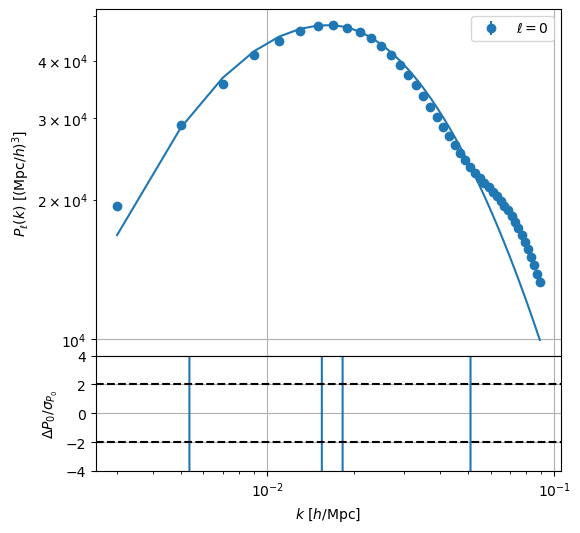

In [10]:
likelihood_temp(**profiles.bestfit.choice(input=True))
observable_temp.plot(scaling='loglog', show=True);

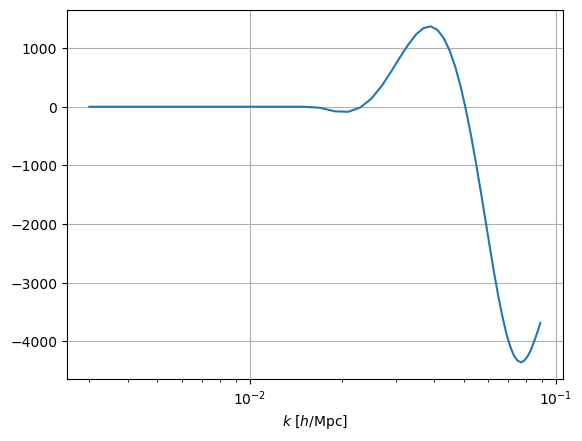

In [11]:
observable_temp(**profiles.bestfit.choice(input=True))
precision, theory_temp = likelihood_temp.precision, observable_temp.flattheory

from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate
template_bao = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
observable_temp.wmatrix.theory.init.update(template=template_bao)
observable_temp(**profiles.bestfit.choice(params=['b1']))
theory_bao = observable_temp.flattheory

# # These are the BAO wiggles
diff = np.array(theory_temp - theory_bao)
diff[observable_temp.k[0] < kTO_fid] = 0
plt.figure()
ax = plt.gca()
ax.plot(observable_temp.k[0], diff)
ax.semilogx()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.show()

In [12]:
def deprojection(precision, template):
    # template has shape (number of parameters, flatdata size)
    template = np.atleast_2d(template).T
    inv = np.linalg.inv(template.T.dot(precision).dot(template))
    return precision - precision.dot(template).dot(inv).dot(template.T).dot(precision)

# Let's deproject BAO, eq. 8 of https://arxiv.org/pdf/2302.07484.pdf
precision_deproj = deprojection(likelihood.precision, diff)

In [13]:
# Let's use the new precision matrix
likelihood.init.update(precision=precision_deproj)

profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize(niterations=2)

print(profiles.to_stats(tablefmt='pretty'))

[000349.68] [0/1] 09-07 11:44  ObservablesGaussianLikelihood INFO     Covariance matrix with 44 points built from 1000 observations.
[000349.68] [0/1] 09-07 11:44  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9550.
[000349.68] [0/1] 09-07 11:44  MinuitProfiler            INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
+------------------------------------+--------+---------+-------+
| chi2 / (44 - 4) = 0.13 / 40 = 0.00 | varied | bestfit | error |
+------------------------------------+--------+---------+-------+
|                 m                  |  True  |  0.63   | 0.27  |
|                 n                  |  True  |  1.025  | 0.075 |
|                qto                 |  True  |  1.010  | 0.075 |
|                 b1                 |  True  |  1.996  | 0.039 |
+------------------------------------+--------+---------+-------+


In [14]:
sampler = EmceeSampler(likelihood, seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.1})

[000353.51] [0/1] 09-07 11:45  EmceeSampler              INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
[000374.36] [0/1] 09-07 11:45  EmceeSampler              INFO     Diagnostics:
[000374.37] [0/1] 09-07 11:45  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.671; not < 0.1.
[000374.38] [0/1] 09-07 11:45  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.107.
[000374.66] [0/1] 09-07 11:45  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.43.
[000374.67] [0/1] 09-07 11:45  EmceeSampler              INFO     - max Geweke is 0.536.
[000374.67] [0/1] 09-07 11:45  EmceeSampler              INFO     - Geweke p-value is 0.216.
[000374.68] [0/1] 09-07 11:45  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 11.2.


/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000397.98] [0/1] 09-07 11:45  EmceeSampler              INFO     Diagnostics:
[000398.00] [0/1] 09-07 11:45  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.122; not < 0.1.
[000398.02] [0/1] 09-07 11:45  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0179.
[000398.80] [0/1] 09-07 11:45  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.108.
[000398.81] [0/1] 09-07 11:45  EmceeSampler              INFO     - max Geweke is 0.396.
[000398.81] [0/1] 09-07 11:45  EmceeSampler              INFO     - Geweke p-value is 0.318.
[000398.83] [0/1] 09-07 11:45  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 13.1.
[000398.83] [0/1] 09-07 11:45  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.555.
[000419.88] [0/1] 09-07 11:46  EmceeSampler              INFO     Diagnostics:
[000419.89] [0/1] 09-07 11:46  EmceeSampler              INFO     

Removed no burn in
Removed no burn in


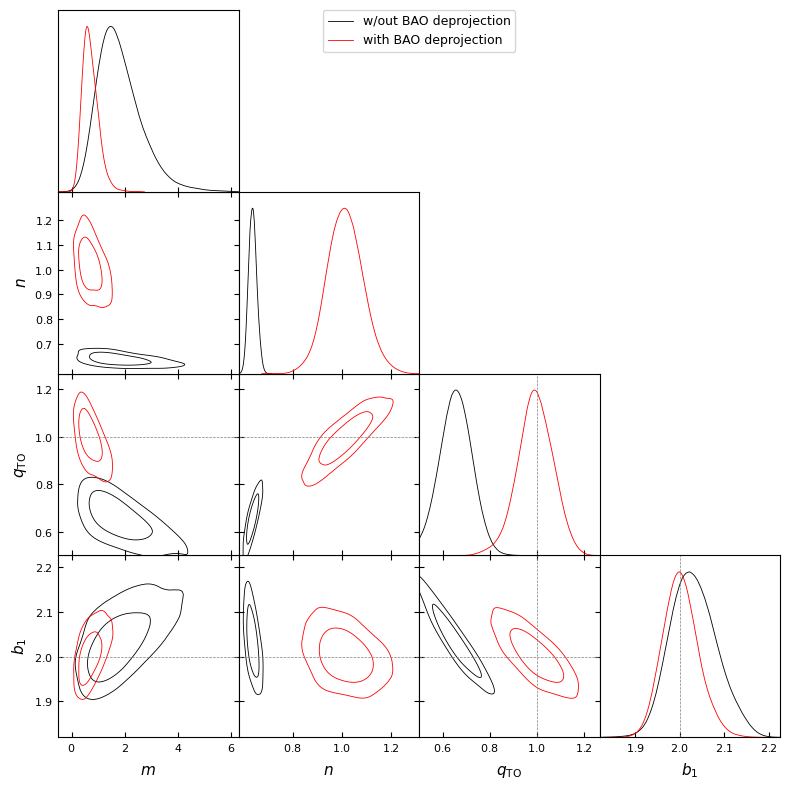

In [15]:
chain_deproj = chains[0].remove_burnin(0.5)[::10]
# Better...
from desilike.samples import plotting
plotting.plot_triangle([chain, chain_deproj], markers={'qto': 1., 'b1': b}, labels=['w/out BAO deprojection', 'with BAO deprojection'], show=True)

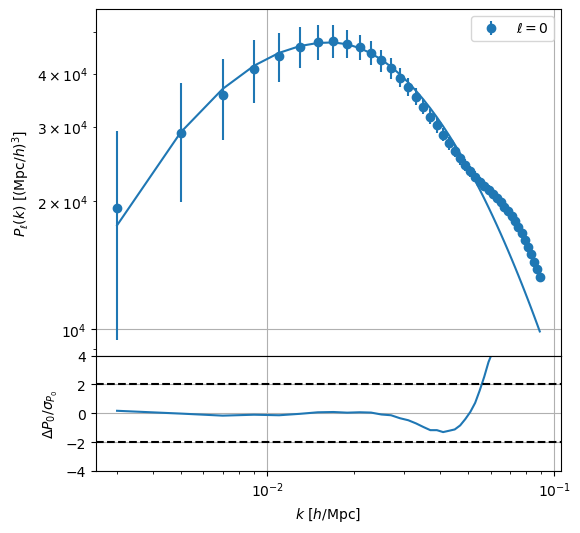

In [16]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot(scaling='loglog', show=True);

In [17]:
print('w/out BAO deprojection:\n{}'.format(chain.to_stats(tablefmt='pretty')))
print('with BAO deprojection:\n{}'.format(chain_deproj.to_stats(tablefmt='pretty')))

w/out BAO deprojection:
+-----+--------+-------+--------+-------+-----------------+-----------------+
|     | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+-----+--------+-------+--------+-------+-----------------+-----------------+
|  m  |  1.45  | 1.81  |  1.68  | 0.85  |   -0.80/+0.79   |   -0.97/+0.54   |
|  n  | 0.642  | 0.638 | 0.638  | 0.017 |  -0.017/+0.017  |  -0.020/+0.013  |
| qto | 0.673  | 0.658 | 0.658  | 0.066 |  -0.069/+0.067  |  -0.064/+0.070  |
| b1  | 2.021  | 2.032 | 2.028  | 0.052 |  -0.052/+0.052  |  -0.054/+0.049  |
+-----+--------+-------+--------+-------+-----------------+-----------------+
with BAO deprojection:
+-----+--------+-------+--------+-------+-----------------+-----------------+
|     | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+-----+--------+-------+--------+-------+-----------------+-----------------+
|  m  |  0.60  | 0.71  |  0.67  | 0.31  |   -0.29/+0.29   |   -0.34/+0.24   |
|  n  | 1.023  | 

## Post-processing
Let's use this measurement of the turn-over scale to put constraints on $h$ (assuming $\Omega_m$).

In [23]:
from desilike.observables.galaxy_clustering import TurnOverCompressionObservable
observable = TurnOverCompressionObservable(data=chain_deproj, covariance=chain_deproj, z=z, quantities=['qto'], fiducial='DESI')

# let's fix Omega_m to its fiducial value, only h is varied
observable.all_params['Omega_m'].update(fixed=True)

# and emulate the observable qto, to speed up the inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples()
emulator.fit()
likelihood = ObservablesGaussianLikelihood(observables=[emulator.to_calculator()])

[000863.26] [0/1] 09-07 11:53  TurnOverCompressionObservable INFO     Found quantities ['qto'].
[000864.81] [0/1] 09-07 11:53  Emulator                  INFO     Varied parameters: ['h'].
[000864.81] [0/1] 09-07 11:53  Emulator                  INFO     Found varying ['flattheory'] and fixed ['flatdata', 'covariance', 'quantities'] outputs.
[000865.12] [0/1] 09-07 11:53  Differentiation           INFO     Varied parameters: ['h'].
[000866.66] [0/1] 09-07 11:53  Differentiation           INFO     Using finite-differentiation for parameter h.
[000866.66] [0/1] 09-07 11:53  Differentiation           INFO     h grid is [0.6536 0.6636 0.6736 0.6836 0.6936].


In [28]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(min_iterations=2000, check={'max_eigen_gr': 0.02})

[001026.61] [0/1] 09-07 11:56  EmceeSampler              INFO     Varied parameters: ['h'].
[001029.77] [0/1] 09-07 11:56  EmceeSampler              INFO     Diagnostics:
[001029.78] [0/1] 09-07 11:56  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0836; not < 0.02.
[001029.78] [0/1] 09-07 11:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0836.
[001029.82] [0/1] 09-07 11:56  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0842.
[001029.82] [0/1] 09-07 11:56  EmceeSampler              INFO     - max Geweke is 0.447.
[001029.82] [0/1] 09-07 11:56  EmceeSampler              INFO     - Geweke p-value is nan.
[001029.82] [0/1] 09-07 11:56  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 15.9.
[001033.24] [0/1] 09-07 11:56  EmceeSampler              INFO     Diagnostics:
[001033.24] [0/1] 09-07 11:56  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.

[Chain(shape=(3000, 4), params=ParameterCollection(['h', 'logposterior', 'Omega_m', 'loglikelihood', 'logprior']))]

Removed no burn in


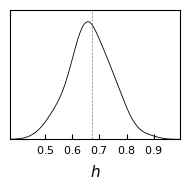

In [29]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
plotting.plot_triangle(chain, markers={'h': cosmo.h})